# NSight System trace analysis

Parsing Nsight System trace exported as JSON

In [1]:
import pandas as pd
import json
from pandas import json_normalize
import numpy as np
from matplotlib import pyplot as plt 
import re

## Functions

In [2]:
# Get all rows from DF with the given correlation ID.
# Search in all df columns with 'correlationId' in the name.
def LookupCorrelationID(corrId, df):  # nvtx, cuda, kernels, sync):
    corrid_columns = [
        c for c in df.columns if c.lower().find('correlationid') >= 0
    ]
    dfcorr = None
    for c in corrid_columns:
        df_ = df[df[c] == corrId]
        if dfcorr is None:
            dfcorr = df_
        else:
            dfcorr = dfcorr.append(df_)
    return dfcorr.dropna(axis=1, how='all')


# Convert columns StartNs and EndNs to
# start and end in seconds.
def convertStartEndTimes(df):
    df_ = df.copy()
    df_['start'] = None
    df_['end'] = None
    start_cols = [c for c in df.columns if c.lower().find('startns') >= 0]
    end_cols = [c for c in df.columns if c.lower().find('endns') >= 0]
    for c in start_cols:
        rows = df_[c].notna()
        df_.loc[rows, 'start'] = df_.loc[rows, c] * 10e-10
    for c in end_cols:
        rows = df_[c].notna()
        df_.loc[rows, 'end'] = df_.loc[rows, c] * 10e-10
    return df_


# Get CUDA kernel names for events with the given correlationIDs
def LookupNamebyCorrID(corrid, df, names):
    dfcorr = LookupCorrelationID(corrid, df)
    #     print('{} events with correlation ID {}'.format(dfcorr.shape[0],corrid))
    if dfcorr.shape[0] == 0:
        return []
    namestrings = []
    if 'CudaEvent.kernel.shortName' in dfcorr.columns:
        if dfcorr['CudaEvent.kernel.shortName'].notna().any():
            shortnames = dfcorr['CudaEvent.kernel.shortName']
            shortnames = shortnames[shortnames.notna()].values
            for ID in shortnames:
                try:
                    n = int(ID)
                except:
                    print('Cannot convert {} to int.'.format(n))
                    continue
                namestrings.append(names[names['id'] == n]['value'].values[0])
    return namestrings


# Return rows that contain string
def searchRowsContaining(s, df):
    mask = df.applymap(lambda x: s.lower() in str(x).lower())
    df_ = df[mask.any(axis=1)]
    return df_


# Search events from df within the time range.
# DF must have 'start' and 'end' columns.
def lookupTimeRange(start, end, df):
    startdf = df[df['start'] >= start]
    rangedf = startdf[startdf['end'] <= end]
    return rangedf


# Combine trace evenets within time range and cuda kernels lookup
def lookupAPIandKernelsInTimerange(start, end, traces, kernels, names):
    # Lookup traces (API) events in the given range
    startdf = traces[traces['start'] >= start]
    rangedf = startdf[startdf['end'] <= end]
    # Store results in the DF
    results = pd.DataFrame(columns=[
        'correlationId', 'api_start', 'api_end', 'kernel', 'start', 'end',
        'duration'
    ])

    for i, row in rangedf.iterrows():
        # Get correlation ID from the trace event
        corrID = row['TraceProcessEvent.correlationId']
        if corrID == 0:
            continue
        # Get CUDA kernel by correlation ID
        kernel_event = LookupCorrelationID(corrID, kernels)
        if kernel_event is None or kernel_event.shape[0] == 0:
            #             print('No kernels for trace event with corrID {}'.format(corrID))
            continue
#         print('kernel for corrID {}'.format(corrID))
#         display(kernel_event)
# Get name of the CUDA kernel
        name = LookupNamebyCorrID(corrID, kernels, names)
        #         print('name for {}: {}'.format(corrID,name))
        # Append to results DF
        results.loc[results.shape[0]] = [
            corrID, row['start'], row['end'], name[0],
            kernel_event['start'].values[0], kernel_event['end'].values[0],
            kernel_event['duration'].values[0]
        ]
    return results


# Find NVTX event which encompasses given trace event
def NVTXforAPIevent(trace_event):
    # Start and end in seconds
    start = trace_event.loc['TraceProcessEvent.startNs'] * 10e-10
    end = trace_event.loc['TraceProcessEvent.endNs'] * 10e-10
#     print('Looking NVTX on range {}-{}'.format(start, end))
    
    # Search NVTX object encompassing events
    nvtxranges = nvtx[nvtx['end'].notna()].copy()
    nvtxranges = nvtxranges[nvtxranges['start'] <= start]
    nvtxranges = nvtxranges[nvtxranges['end'] >= end]
#     print('Found {} ranges'.format(nvtxranges.shape[0]))
    names = nvtxranges['NvtxEvent.Text'].values
    return names


# Return True if the row value contains any of event name patterns
def searchEventPattern(row, event_names=None, debug=False):
    s = row.loc['value']
    for pattern in event_names:
        m = re.search(pattern, s, re.I)
        if m is not None:
            return True
        else:
            if debug:
                print("{} not found in {}".format(pattern, s))
    return False

## Read JSON

In [5]:
json_file = "logs/DL.cont/traces/20200803/nsys_trace_20.json"
data = [json.loads(line) for line in open(json_file, 'r')]

df = json_normalize(data)
int_columns = [
    'NvtxEvent.Timestamp',
    'NvtxEvent.EndTimestamp',
    'CudaEvent.startNs',
    'CudaEvent.endNs',
    'CudaEvent.correlationId',
    'CudaEvent.sync.eventId',
    'TraceProcessEvent.correlationId',
    'TraceProcessEvent.name',
    'TraceProcessEvent.startNs',
    'TraceProcessEvent.endNs',
    'id'
]
for c in int_columns:
    df[c] = df[c].fillna(-1).astype(int).replace(-1, np.nan)
#     df[c] = df[c].astype(int)

df.sample(n=5)

,type,id,value,globalPid,filename,content,Type,CommEvent.Timestamp,CommEvent.GlobalPid,CommEvent.NumOfCpus,...,CudaEvent.kernel.localMemoryTotal,CudaEvent.kernel.gridId,CudaEvent.kernel.registersPerThread,CudaEvent.kernel.sharedMemoryExecuted,CudaEvent.kernel.cacheConfig,CudaEvent.kernel.launched,CudaEvent.kernel.sharedMemoryConfig,globalTid,nameId,priority
3635,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5808,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4177,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6169,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6695,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("Read {} rows.".format(df.shape[0]))
print('\n'.join(df.columns))

Read 13134 rows.
type
id
value
globalPid
filename
content
Type
CommEvent.Timestamp
CommEvent.GlobalPid
CommEvent.NumOfCpus
CommEvent.Command
CommEvent.Commname
CommEvent.PathToExe
CommEvent.WorkDir
CommEvent.Args
CommEvent.Bitness
CommEvent.NsTime
CommEvent.EnvironId
DiagnosticEvent.Timestamp.Time
DiagnosticEvent.Timestamp.Type
DiagnosticEvent.Timestamp.NsTime
DiagnosticEvent.Source
DiagnosticEvent.Level
DiagnosticEvent.Text
DiagnosticEvent.GlobalProcess
TraceProcessEvent.startNs
TraceProcessEvent.endNs
TraceProcessEvent.correlationId
TraceProcessEvent.eventClass
TraceProcessEvent.name
TraceProcessEvent.returnValue
TraceProcessEvent.globalTid
NvtxEvent.Type
NvtxEvent.Timestamp
NvtxEvent.Text
NvtxEvent.GlobalTid
NvtxEvent.EndTimestamp
NvtxEvent.DomainId
NvtxEvent.NsTime
CudaEvent.startNs
CudaEvent.endNs
CudaEvent.correlationId
CudaEvent.deviceId
CudaEvent.contextId
CudaEvent.streamId
CudaEvent.eventClass
CudaEvent.globalPid
CudaEvent.memcpy.sizebytes
CudaEvent.memcpy.copyKind
CudaEvent.

## Create DF for each type of objects: NVTX, trace, sync, CUDA events and CUDA kernels

In [7]:
# Create detaframes for each event type
# NVTX objects that have NvtxEvent Timestamp
nvtx = df[df['NvtxEvent.Timestamp'].notna()].dropna(axis=1, how='all')
# Convert to seconds as displayed in the Nsight System window
nvtx['start'] = nvtx['NvtxEvent.Timestamp'] * 10e-10
nvtx['end'] = nvtx['NvtxEvent.EndTimestamp'].fillna(0) * 10e-10
nvtx['end'] = nvtx['end'].replace(0, np.nan)

traces = df[df['TraceProcessEvent.startNs'].notna()].dropna(axis=1, how='all')
traces['start'] = traces['TraceProcessEvent.startNs'] * 10e-10
traces['end'] = traces['TraceProcessEvent.endNs'] * 10e-10
traces['duration'] = (traces['TraceProcessEvent.endNs'] -
                      traces['TraceProcessEvent.startNs']) * 10e-10

sync = df[df['CudaEvent.sync.eventId'].notna()].dropna(axis=1, how='all')
# Convert to seconds
sync['start'] = sync['CudaEvent.startNs'] * 10e-10
sync['end'] = sync['CudaEvent.endNs'] * 10e-10
sync['duration'] = (sync['CudaEvent.endNs'] - sync['CudaEvent.startNs']) * 10e-10

# CUDA event kernels objects
kernels = df[df['CudaEvent.kernel.shortName'].notna()].dropna(axis=1, how='all')
# Convert to seconds
kernels['start'] = kernels['CudaEvent.startNs'] * 10e-10
kernels['end'] = kernels['CudaEvent.endNs'] * 10e-10
kernels['duration'] = (kernels['CudaEvent.endNs'] - kernels['CudaEvent.startNs']) * 10e-10

# Names
names = df[df['value'].notna()].dropna(axis=1, how='all')


print('Names')
display(names.head())
print('NVTX')
display(nvtx.head())
print('traces')
display(traces[traces['duration']>0.00002].head(5))
print('Trace event names',sorted(list(traces['TraceProcessEvent.name'].unique())))
print('sync')
display(sync.head())
# print('CUDA')
# display(cuda.head())
print('kernels')
display(kernels.head())

Names


,type,id,value
0,String,0.0,[Unknown]
1,String,1.0,[kernel.kallsyms]
2,String,2.0,[Max depth]
3,String,3.0,[Broken backtraces]
4,String,4.0,[Called from Java]


NVTX


,Type,NvtxEvent.Type,NvtxEvent.Timestamp,NvtxEvent.Text,NvtxEvent.GlobalTid,NvtxEvent.EndTimestamp,NvtxEvent.DomainId,NvtxEvent.NsTime,NvtxEvent.Color,start,end
287,59.0,59.0,1.808673e+09,Moving model to GPU,282072782506800,5.535899e+09,0,True,NaN,1.808673,5.535899
2217,34.0,34.0,5.536977e+09,Epoch 0 start,282072782506800,NaN,0,True,8.612608e+08,5.536977,NaN
2218,34.0,34.0,5.536983e+09,Training epoch start,282072782506800,NaN,0,True,NaN,5.536983,NaN
2225,59.0,59.0,5.900168e+09,Iteration 1,282072782506800,6.125082e+09,0,True,4.278223e+09,5.900168,6.125082
2235,59.0,59.0,5.902569e+09,FWD pass,282072782506800,5.987051e+09,0,True,4.286513e+09,5.902569,5.987051


traces


,Type,TraceProcessEvent.startNs,TraceProcessEvent.endNs,TraceProcessEvent.correlationId,TraceProcessEvent.eventClass,TraceProcessEvent.name,TraceProcessEvent.returnValue,TraceProcessEvent.globalTid,start,end,duration
274,48.0,7.100767e+08,7.528554e+08,0.0,3.0,34.0,0.0,282072782506800,0.710077,0.752855,0.042779
277,48.0,7.528610e+08,7.843868e+08,0.0,3.0,36.0,0.0,282072782506800,0.752861,0.784387,0.031526
280,48.0,1.088013e+09,1.112046e+09,0.0,3.0,38.0,0.0,282072782506800,1.088013,1.112046,0.024032
285,48.0,1.808642e+09,1.808666e+09,0.0,3.0,39.0,0.0,282072782506800,1.808642,1.808666,0.000024
288,48.0,1.808938e+09,5.485429e+09,228.0,0.0,61.0,0.0,282072782506800,1.808938,5.485429,3.676490


Trace event names [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 55.0, 56.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 77.0, 145.0, 148.0, 208.0, 209.0, 210.0, 211.0, 214.0, 215.0, 216.0, 217.0, 218.0]
sync


,Type,CudaEvent.startNs,CudaEvent.endNs,CudaEvent.correlationId,CudaEvent.deviceId,CudaEvent.contextId,CudaEvent.streamId,CudaEvent.eventClass,CudaEvent.globalPid,CudaEvent.sync.eventId,CudaEvent.sync.syncType,start,end,duration
927,106.0,5.485624e+09,5.485631e+09,233.0,0.0,1,7,5.0,282072782471168,4.294967e+09,3.0,5.485624,5.485631,0.000007
930,106.0,5.485929e+09,5.485935e+09,242.0,0.0,1,7,5.0,282072782471168,4.294967e+09,3.0,5.485929,5.485935,0.000006
934,106.0,5.485982e+09,5.485988e+09,251.0,0.0,1,7,5.0,282072782471168,4.294967e+09,3.0,5.485982,5.485988,0.000006
938,106.0,5.486031e+09,5.486037e+09,260.0,0.0,1,7,5.0,282072782471168,4.294967e+09,3.0,5.486031,5.486037,0.000006
942,106.0,5.486065e+09,5.486071e+09,269.0,0.0,1,7,5.0,282072782471168,4.294967e+09,3.0,5.486065,5.486071,0.000006


kernels


,Type,CudaEvent.startNs,CudaEvent.endNs,CudaEvent.correlationId,CudaEvent.deviceId,CudaEvent.contextId,CudaEvent.streamId,CudaEvent.eventClass,CudaEvent.globalPid,CudaEvent.kernel.demangledName,...,CudaEvent.kernel.localMemoryTotal,CudaEvent.kernel.gridId,CudaEvent.kernel.registersPerThread,CudaEvent.kernel.sharedMemoryExecuted,CudaEvent.kernel.cacheConfig,CudaEvent.kernel.launched,CudaEvent.kernel.sharedMemoryConfig,start,end,duration
2304,79.0,5.906826e+09,5.906828e+09,3337.0,0.0,1,7,3.0,282072782471168,75,...,51904512.0,1,15.0,0.0,1.0,1.0,0.0,5.906826,5.906828,0.000002
2306,79.0,5.906947e+09,5.908102e+09,3340.0,0.0,1,7,3.0,282072782471168,65,...,51904512.0,2,125.0,32768.0,1.0,1.0,0.0,5.906947,5.908102,0.001155
2310,79.0,5.908104e+09,5.908107e+09,3352.0,0.0,1,7,3.0,282072782471168,78,...,51904512.0,3,18.0,0.0,1.0,1.0,0.0,5.908104,5.908107,0.000003
2313,79.0,5.908743e+09,5.909564e+09,3393.0,0.0,1,7,3.0,282072782471168,130,...,51904512.0,4,32.0,1024.0,1.0,1.0,0.0,5.908743,5.909564,0.000821
2316,79.0,5.909566e+09,5.910072e+09,3401.0,0.0,1,7,3.0,282072782471168,132,...,51904512.0,5,8.0,0.0,1.0,1.0,0.0,5.909566,5.910072,0.000506


In [8]:
# Search events matching patterns
event_name_patterns = ['.*cudaStreamSynchronize.*']
event_names_df = names[names.apply(searchEventPattern, event_names = event_name_patterns, axis=1)]
print('Matched Events:')
print(event_names_df)

if event_names_df.shape[0] == 0:
    print("Found no events matching patterns {}.".format(args.events))

Matched Events:
      type    id                        value
63  String  63.0  cudaStreamSynchronize_v3020


In [9]:
# Search trace events (cuDNN, cuBLAS API events, CPU side)
df_ = traces.copy()
API_events = df_[df_['TraceProcessEvent.name'].isin(event_names_df['id'])].dropna(
    axis=1, how='all')
print("Found {} API events".format(API_events.shape[0]))
if API_events.shape[0] == 0:
    sys.exit(0)
    
# Store API event names
API_events['name'] = API_events['TraceProcessEvent.name'].apply(lambda x: event_names_df[event_names_df['id']==x]['value'].values[0])
print("Columns\n{}".format(API_events.columns))
display(API_events)
print(API_events['name'].unique())                 

Found 330 API events
Columns
Index(['Type', 'TraceProcessEvent.startNs', 'TraceProcessEvent.endNs',
       'TraceProcessEvent.correlationId', 'TraceProcessEvent.eventClass',
       'TraceProcessEvent.name', 'TraceProcessEvent.returnValue',
       'TraceProcessEvent.globalTid', 'start', 'end', 'duration', 'name'],
      dtype='object')


,Type,TraceProcessEvent.startNs,TraceProcessEvent.endNs,TraceProcessEvent.correlationId,TraceProcessEvent.eventClass,TraceProcessEvent.name,TraceProcessEvent.returnValue,TraceProcessEvent.globalTid,start,end,duration,name
926,48.0,5.485623e+09,5.485631e+09,233.0,0.0,63.0,0.0,282072782506800,5.485623,5.485631,0.000008,cudaStreamSynchronize_v3020
929,48.0,5.485929e+09,5.485936e+09,242.0,0.0,63.0,0.0,282072782506800,5.485929,5.485936,0.000007,cudaStreamSynchronize_v3020
933,48.0,5.485981e+09,5.485988e+09,251.0,0.0,63.0,0.0,282072782506800,5.485981,5.485988,0.000007,cudaStreamSynchronize_v3020
937,48.0,5.486030e+09,5.486037e+09,260.0,0.0,63.0,0.0,282072782506800,5.486030,5.486037,0.000006,cudaStreamSynchronize_v3020
941,48.0,5.486065e+09,5.486071e+09,269.0,0.0,63.0,0.0,282072782506800,5.486065,5.486071,0.000007,cudaStreamSynchronize_v3020
...,...,...,...,...,...,...,...,...,...,...,...,...
9113,48.0,6.308149e+09,6.308158e+09,30925.0,0.0,63.0,0.0,282072782506800,6.308149,6.308158,0.000009,cudaStreamSynchronize_v3020
9125,48.0,6.312213e+09,6.313311e+09,30982.0,0.0,63.0,0.0,282072782506800,6.312213,6.313311,0.001098,cudaStreamSynchronize_v3020
9129,48.0,6.313360e+09,6.313367e+09,30991.0,0.0,63.0,0.0,282072782506800,6.313360,6.313367,0.000007,cudaStreamSynchronize_v3020
12908,48.0,6.492948e+09,6.492957e+09,45556.0,0.0,63.0,0.0,282072782506800,6.492948,6.492957,0.000009,cudaStreamSynchronize_v3020


['cudaStreamSynchronize_v3020']


### NVTX encompassing API events

In [10]:
# Search NVTX reagons encompassing API events
API_events['NVTX'] = API_events.apply(NVTXforAPIevent, axis=1)
display(API_events)

,Type,TraceProcessEvent.startNs,TraceProcessEvent.endNs,TraceProcessEvent.correlationId,TraceProcessEvent.eventClass,TraceProcessEvent.name,TraceProcessEvent.returnValue,TraceProcessEvent.globalTid,start,end,duration,name,NVTX
926,48.0,5.485623e+09,5.485631e+09,233.0,0.0,63.0,0.0,282072782506800,5.485623,5.485631,0.000008,cudaStreamSynchronize_v3020,[Moving model to GPU]
929,48.0,5.485929e+09,5.485936e+09,242.0,0.0,63.0,0.0,282072782506800,5.485929,5.485936,0.000007,cudaStreamSynchronize_v3020,[Moving model to GPU]
933,48.0,5.485981e+09,5.485988e+09,251.0,0.0,63.0,0.0,282072782506800,5.485981,5.485988,0.000007,cudaStreamSynchronize_v3020,[Moving model to GPU]
937,48.0,5.486030e+09,5.486037e+09,260.0,0.0,63.0,0.0,282072782506800,5.486030,5.486037,0.000006,cudaStreamSynchronize_v3020,[Moving model to GPU]
941,48.0,5.486065e+09,5.486071e+09,269.0,0.0,63.0,0.0,282072782506800,5.486065,5.486071,0.000007,cudaStreamSynchronize_v3020,[Moving model to GPU]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9113,48.0,6.308149e+09,6.308158e+09,30925.0,0.0,63.0,0.0,282072782506800,6.308149,6.308158,0.000009,cudaStreamSynchronize_v3020,[Iteration 2]
9125,48.0,6.312213e+09,6.313311e+09,30982.0,0.0,63.0,0.0,282072782506800,6.312213,6.313311,0.001098,cudaStreamSynchronize_v3020,[Iteration 3]
9129,48.0,6.313360e+09,6.313367e+09,30991.0,0.0,63.0,0.0,282072782506800,6.313360,6.313367,0.000007,cudaStreamSynchronize_v3020,[Iteration 3]
12908,48.0,6.492948e+09,6.492957e+09,45556.0,0.0,63.0,0.0,282072782506800,6.492948,6.492957,0.000009,cudaStreamSynchronize_v3020,[Iteration 3]


### Search CUDA API calls

In [11]:
# Search CUDA API calls for each API event
cudakernels = None
for _, row in API_events.iterrows():
    start = row.loc['start']
    end = row.loc['end']
    APIname = row['name']
    NVTX_arr = row['NVTX']    
    df_ = lookupAPIandKernelsInTimerange(start, end, traces, kernels, names)
    print('{}kernels for {:} {} ({:.4f}-{:.4f})'.format(
        df_.shape[0], APIname, NVTX_arr, start, end))
    df_['API event'] = APIname
    df_['NVTX'] = df_.apply(lambda x: NVTX_arr, axis=1)
#     display(df_)
    if cudakernels is None:
        cudakernels = df_
    else:
        cudakernels = cudakernels.append(df_, ignore_index=True)
    

display(cudakernels.head())
print('...')
display(cudakernels.tail())
print(cudakernels.shape[0])

0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4856-5.4856)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4859-5.4859)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4860-5.4860)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4860-5.4860)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4861-5.4861)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4861-5.4861)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4863-5.4863)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4863-5.4863)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4864-5.4864)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4864-5.4864)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4864-5.4864)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4865-5.4865)
0kernels for cudaStreamSynch

0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4924-5.4924)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4925-5.4925)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4925-5.4925)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4926-5.4926)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4926-5.4926)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4926-5.4926)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4927-5.4928)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4928-5.4928)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4928-5.4929)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4929-5.4929)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4929-5.4929)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.4930-5.4930)
0kernels for cudaStreamSynch

0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5086-5.5086)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5086-5.5086)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5087-5.5087)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5087-5.5087)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5091-5.5092)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5093-5.5093)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5094-5.5094)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5094-5.5094)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5094-5.5094)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5095-5.5095)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5102-5.5103)
0kernels for cudaStreamSynchronize_v3020 ['Moving model to GPU'] (5.5104-5.5104)
0kernels for cudaStreamSynch

,correlationId,api_start,api_end,kernel,start,end,duration,API event,NVTX


...


,correlationId,api_start,api_end,kernel,start,end,duration,API event,NVTX


0


In [132]:
def GetIterationNumber(nvtx_arr):
    nvtx_name = [n for n in nvtx_arr if 'iteration' in n.lower()]
    nvtx_name = nvtx_name[0] # Convert list to string
    s = nvtx_name.replace('Iteration ','')
    try:
        i = int(s)
    except:
        print('Cannot convert {} to int'.format(s))
        return None
    return i
    

In [133]:
cudakernels['iteration'] = cudakernels['NVTX'].apply(GetIterationNumber)
cudakernels.sample(n=5)

,correlationId,api_start,api_end,kernel,start,end,duration,API event,NVTX,iteration
14,4652.0,4.832481,4.832492,bn_fw_tr_1C11_singleread,4.877805,4.878505,0.000699,cudnnBatchNormalizationForwardTrainingEx,"[Iteration 1, FWD pass]",1
117,13387.0,4.976197,4.976204,bn_bw_1C11_kernel_new,5.193924,5.196536,0.002612,cudnnBatchNormalizationBackwardEx,"[Iteration 1, BWD pass]",1
47,7571.0,4.844819,4.844829,bn_fw_tr_1C11_singleread,4.950720,4.950818,0.000098,cudnnBatchNormalizationForwardTrainingEx,"[Iteration 1, FWD pass]",1
189,23207.0,5.246638,5.246646,bn_bw_1C11_singleread,5.380671,5.380765,0.000094,cudnnBatchNormalizationBackwardEx,"[Iteration 2, BWD pass]",2
53,8096.0,4.961305,4.961345,sgemm_32x32x32_NT_vec,4.961344,4.961532,0.000188,cublasSgemm_v2,"[Iteration 1, FWD pass]",1


## Aggregate Time of all selected kernels for each iteration

In [134]:
agg_kernels = cudakernels[['duration','iteration']].groupby(['iteration']).sum()
agg_kernels

,duration
iteration,
1,0.068568
2,0.064620


In [20]:
def getAPIevent(corrId):
#     print('Got corrID {}'.format(corrId))
    nvtxevent = NVTXforAPIevent(corrId, traces, nvtx)
    return nvtxevent.iloc[0]['NvtxEvent.Text']

In [25]:
def GetIterationNumber(nvtx_name):
    s = nvtx_name.replace('Iteration ','')
    try:
        i = int(s)
    except:
        print('Cannot convert {} to int'.format(s))
        return None
    return i

38
42
41
Means event
convolutionBackwardData      0.202053
convolutionBackwardFilter    0.212434
convolutionForward           0.240462
convolutionSum               0.654949
dtype: float64
Mean SUM of convolution operations = 0.6549(s)


event,convolutionBackwardData,convolutionBackwardFilter,convolutionForward,convolutionSum
iteration,,,,
1,0.205018,0.214120,0.297333,0.716471
2,0.201366,0.211477,0.233973,0.646816
3,0.205031,0.214358,0.232811,0.652200
4,0.201570,0.211920,0.232898,0.646387
5,0.198848,0.210229,0.235373,0.644450
6,0.199936,0.211202,0.235204,0.646342
7,0.204199,0.214191,0.232123,0.650513
8,0.202545,0.211976,0.235787,0.650308
9,0.200954,0.212375,0.235033,0.648362


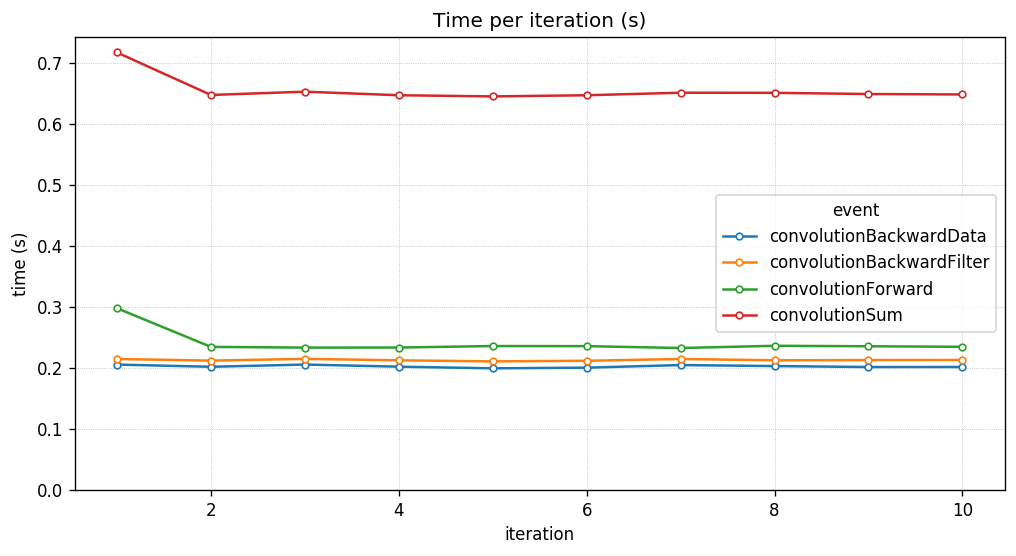

In [45]:
APIevents = ['convolutionForward', 'convolutionBackwardFilter', 'convolutionBackwardData']
df_itertimes = None
for APIevent_name in APIevents:
    # Find ID for the given event name
    APIevent = searchRowsContaining(APIevent_name,names)
    # display(APIevent)
    APIevent_id = APIevent.iloc[0]['id'].astype(int)
    print(APIevent_id)
    # Find events with this ID
    df_APIevents = traces[traces['TraceProcessEvent.name']==APIevent_id].dropna(axis=1, how='all')
    # DF for storing results
    # One row for each CUDA kernel
    df_results = None
    for i, api_range in df_APIevents.iterrows():
    #     print(i)
    #     print(api_range)
        api_start = api_range['start']
        api_end = api_range['end']
        kernels_ = lookupAPIandKernelsInTimerange(api_start, api_end, traces,
                                                  kernels, names)
        kernels_['nvtx'] = kernels_['correlationId'].apply(getAPIevent)
        if df_results is None:
            df_results = kernels_
        else:
            df_results = df_results.append(kernels_, ignore_index=True)

    itertimes = df_results[['duration','nvtx']].groupby(['nvtx'],as_index=False).sum()
    itertimes['iteration'] = itertimes['nvtx'].apply(GetIterationNumber)
    itertimes.sort_values(by=['iteration'],inplace=True)
    itertimes['event'] = APIevent_name
    if df_itertimes is None:
        df_itertimes = itertimes
    else:
        df_itertimes = df_itertimes.append(itertimes, ignore_index=True)

df_itertimesT = df_itertimes.pivot_table(index='iteration',columns='event',values='duration')
df_itertimesT['convolutionSum'] = df_itertimesT.agg('sum',axis='columns')
means = df_itertimesT.agg('mean')
print('Means',means)
mean = df_itertimesT['convolutionSum'].agg('mean')
print('Mean SUM of convolution operations = {:5.4f}(s)'.format(mean))
display(df_itertimesT)
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
df_itertimesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.set_ylim(0, None)
ax.grid(ls=':', lw=0.5, alpha=0.9)
ax.set_title('Time per iteration (s)')
ax.set_ylabel('time (s)')
plt.show()

In [43]:
NVTXnames = ['Prediction and loss', 'Optimizer update']
for nvtx_name in NVTXnames:
    APIevents = searchRowsContaining(nvtx_name, df).dropna(axis=1, how='all')
    display(APIevents)
    df_other_itertimes = None
    for APIevent in APIevents:
        # Find ID for the given event name
        
        APIevent_id = APIevent.iloc[0]['id'].astype(int)
        print(APIevent_id)
        # Find events with this ID
        df_APIevents = traces[traces['TraceProcessEvent.name']==APIevent_id].dropna(axis=1, how='all')
        # DF for storing results
        # One row for each CUDA kernel
        df_results = None
        for i, api_range in df_APIevents.iterrows():
        #     print(i)
        #     print(api_range)
            api_start = api_range['start']
            api_end = api_range['end']
            kernels_ = lookupAPIandKernelsInTimerange(api_start, api_end, traces,
                                                      kernels, names)
            kernels_['nvtx'] = kernels_['correlationId'].apply(getAPIevent)
            if df_results is None:
                df_results = kernels_
            else:
                df_results = df_results.append(kernels_, ignore_index=True)

        itertimes = df_results[['duration','nvtx']].groupby(['nvtx'],as_index=False).sum()
        itertimes['iteration'] = itertimes['nvtx'].apply(GetIterationNumber)
        itertimes.sort_values(by=['iteration'],inplace=True)
        itertimes['event'] = APIevent_name
        if df_other_itertimes is None:
            df_other_itertimes = itertimes
        else:
            df_other_itertimes = df_other_itertimes.append(itertimes, ignore_index=True)

df_other_itertimesT = df_other_itertimes.pivot_table(index='iteration',columns='event',values='duration')
df_other_itertimesT['convolutionSum'] = df_other_itertimesT.agg('sum',axis='columns')
mean = df_other_itertimesT['convolutionSum'].mean()
print('Mean SUM of convolution operations = {:5.4f}(s)'.format(mean))
display(df_other_itertimesT)
fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
df_other_itertimesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.set_ylim(0, None)
ax.grid(ls=':', lw=0.5, alpha=0.9)
ax.set_title('Time per iteration (s)')
ax.set_ylabel('time (s)')
plt.show()

,Type,NvtxEvent.Type,NvtxEvent.Timestamp,NvtxEvent.Text,NvtxEvent.GlobalTid,NvtxEvent.EndTimestamp,NvtxEvent.DomainId,NvtxEvent.NsTime,NvtxEvent.Color
2606,59.0,59.0,5.067373e+09,Prediction and loss,284720848106429,5.067990e+09,0,True,4.294902e+09
8433,59.0,59.0,5.680956e+09,Prediction and loss,284720848106429,5.681161e+09,0,True,4.294902e+09
14811,59.0,59.0,6.563544e+09,Prediction and loss,284720848106429,6.563741e+09,0,True,4.294902e+09
21188,59.0,59.0,7.453050e+09,Prediction and loss,284720848106429,7.453255e+09,0,True,4.294902e+09
27565,59.0,59.0,8.336877e+09,Prediction and loss,284720848106429,8.337077e+09,0,True,4.294902e+09
33942,59.0,59.0,9.217772e+09,Prediction and loss,284720848106429,9.217978e+09,0,True,4.294902e+09
40319,59.0,59.0,1.010236e+10,Prediction and loss,284720848106429,1.010256e+10,0,True,4.294902e+09
46696,59.0,59.0,1.098844e+10,Prediction and loss,284720848106429,1.098865e+10,0,True,4.294902e+09
53073,59.0,59.0,1.187554e+10,Prediction and loss,284720848106429,1.187575e+10,0,True,4.294902e+09
59450,59.0,59.0,1.276058e+10,Prediction and loss,284720848106429,1.276079e+10,0,True,4.294902e+09


AttributeError: 'str' object has no attribute 'iloc'